# DQN on CartPole-v1 with Stable Baselines 3

This notebook replicates MATLAB’s Reinforcement Learning Designer Cart-Pole example (DQN, discrete actions) in Python using Stable Baselines 3, see also [here](https://se.mathworks.com/help/reinforcement-learning/ug/design-dqn-using-rl-designer.html).

Note: the cartpole is part of the gymnasium (formerly gym) examples. stable_baselines3 only works with gymnasium for versions equal or newer than 2.0.0 due to changes in the ```step``` function. 


## 1. Setup & Dependencies

In [1]:
# %%
#!pip install stable-baselines3[extra] matplotlib
import os
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, X_TIMESTEPS
import matplotlib.pyplot as plt
import numpy as np

# visualisation in Jupyter
from matplotlib import animation
from IPython.display import HTML

## 2. Import & Inspect the CartPole Environment

In [16]:
env = gym.make("CartPole-v1", render_mode="rgb_array") # Discrete(2) actions, Box(4,) observations  [oai_citation:1‡gymlibrary.dev](https://www.gymlibrary.dev/environments/classic_control/cart_pole/?utm_source=chatgpt.com)
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env_Monitor = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))             # Record episode rewards

print("Observation space:", env.observation_space)
print("Action space     :", env.action_space)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space     : Discrete(2)


## 3. Create a DQN Agent

We mirror the MATLAB defaults but tweak hyperparameters (hidden layers, learning rate) as in the Designer app:

- **Policy:** MLP with two hidden layers of 128 units (instead of default 256)  
- **Learning rate:** 2e-4  
- **Replay buffer:** 50 000  
- **Batch size:** 32 sampled from replay buffer
- **poliak upate factor $\tau$**: 1.0 corresponds to a hard update of the target Q-network
- **γ (discount):** 0.99
- **exploration_fraction**: fraction of training over which exploration is reduced
- **exploration final eps**: final value of $\epsilon$ for exploration (starting from 1.0)
- **learning starts**: Use first 10 000 steps to fill up replay buffer and ensure diversity in experience
- **training frequency**: Q-network is updated every 4 steps. 
- **target update interval**: every 1000 steps the target network is overwritten with the (learned) Q-network


In [7]:
model = DQN(
    policy="MlpPolicy",
    env=env_Monitor,
    learning_rate=2e-4,
    buffer_size=50_000,
    batch_size=32,
    tau=1.0, 
    gamma=0.99, 
    exploration_fraction=0.3, 
    exploration_final_eps=0.01,  
    learning_starts=10_000,
    train_freq=4, # model update every 4 steps
    target_update_interval=1_000, # how often the target network is updated
    verbose=1, # activate info messages
    policy_kwargs=dict(net_arch=[128, 128]),    # two hidden layers with 128 units each
)

Using cpu device
Wrapping the env in a DummyVecEnv.


## 4. Train with Evaluation Callback

We train up to 200 000 steps, evaluating every 5 000 steps and saving the best model. When evaluating, the current best policy is applied without exploration (i.e., actions are chosen deterministically)

In [9]:
eval_callback = EvalCallback(
    env,
    #best_model_save_path="./logs/",
    #log_path="./logs/",
    eval_freq=5_000,
    n_eval_episodes=5,
    deterministic=True,
)

model.learn(total_timesteps=200_000, callback=eval_callback, progress_bar=True)

Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.5     |
|    ep_rew_mean      | 23.5     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 697      |
|    time_elapsed     | 0        |
|    total_timesteps  | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | 22.8     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1178     |
|    time_elapsed     | 0        |
|    total_timesteps  | 182      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.6     |
|    ep_rew_mean      | 24.6     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes       

Eval num_timesteps=5000, episode_reward=9.60 +/- 0.80

Episode length: 9.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.6      |
|    mean_reward      | 9.6      |
| rollout/            |          |
|    exploration_rate | 0.918    |
| time/               |          |
|    total_timesteps  | 5000     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.7     |
|    ep_rew_mean      | 24.7     |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 5875     |
|    time_elapsed     | 0        |
|    total_timesteps  | 5038     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25       |
|    ep_rew_mean      | 25       |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 5899     |
|    time_elapsed     | 0        |
|    total_timesteps  | 5147     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.4     |
|    ep_rew_mean      | 25.4     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes       

Eval num_timesteps=10000, episode_reward=9.60 +/- 0.80

Episode length: 9.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.6      |
|    mean_reward      | 9.6      |
| rollout/            |          |
|    exploration_rate | 0.835    |
| time/               |          |
|    total_timesteps  | 10000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 432      |
|    fps              | 5956     |
|    time_elapsed     | 1        |
|    total_timesteps  | 10069    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.389    |
|    n_updates        | 17       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rat

Eval num_timesteps=15000, episode_reward=30.00 +/- 2.28

Episode length: 30.00 +/- 2.28

----------------------------------
| eval/               |          |
|    mean_ep_length   | 30       |
|    mean_reward      | 30       |
| rollout/            |          |
|    exploration_rate | 0.753    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.016    |
|    n_updates        | 1249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.9     |
|    ep_rew_mean      | 26.9     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 652      |
|    fps              | 1837     |
|    time_elapsed     | 8        |
|    total_timesteps  | 15096    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.409    |
|    n_updates        | 1273     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | 27.1     |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 656      |
|    fps              | 1805     |
|    time_elapsed     | 8        |
|    total_timesteps  | 15209    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.106    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=329.20 +/- 63.31

Episode length: 329.20 +/- 63.31

----------------------------------
| eval/               |          |
|    mean_ep_length   | 329      |
|    mean_reward      | 329      |
| rollout/            |          |
|    exploration_rate | 0.67     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.239    |
|    n_updates        | 2499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.7     |
|    ep_rew_mean      | 41.7     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 772      |
|    fps              | 1092     |
|    time_elapsed     | 18       |
|    total_timesteps  | 20068    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.57     |
|    n_updates        | 2516     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 42.4     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 776      |
|    fps              | 1087     |
|    time_elapsed     | 18       |
|    total_timesteps  | 20239    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0132   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=131.20 +/- 16.15

Episode length: 131.20 +/- 16.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 131      |
|    mean_reward      | 131      |
| rollout/            |          |
|    exploration_rate | 0.588    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.698    |
|    n_updates        | 3749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.2     |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 852      |
|    fps              | 902      |
|    time_elapsed     | 27       |
|    total_timesteps  | 25062    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.757    |
|    n_updates        | 3765     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=244.60 +/- 51.08

Episode length: 244.60 +/- 51.08

----------------------------------
| eval/               |          |
|    mean_ep_length   | 245      |
|    mean_reward      | 245      |
| rollout/            |          |
|    exploration_rate | 0.505    |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00577  |
|    n_updates        | 4999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.7     |
|    ep_rew_mean      | 82.7     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 908      |
|    fps              | 829      |
|    time_elapsed     | 36       |
|    total_timesteps  | 30319    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0251   |
|    n_updates        | 5079     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=200.20 +/- 26.62

Episode length: 200.20 +/- 26.62

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 200      |
| rollout/            |          |
|    exploration_rate | 0.423    |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.31     |
|    n_updates        | 6249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | 104      |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 948      |
|    fps              | 780      |
|    time_elapsed     | 45       |
|    total_timesteps  | 35486    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00511  |
|    n_updates        | 6371     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=216.40 +/- 24.89

Episode length: 216.40 +/- 24.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 216      |
|    mean_reward      | 216      |
| rollout/            |          |
|    exploration_rate | 0.34     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.631    |
|    n_updates        | 7499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | 128      |
|    exploration_rate | 0.335    |
| time/               |          |
|    episodes         | 980      |
|    fps              | 744      |
|    time_elapsed     | 54       |
|    total_timesteps  | 40279    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.612    |
|    n_updates        | 7569     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=177.80 +/- 11.57

Episode length: 177.80 +/- 11.57

----------------------------------
| eval/               |          |
|    mean_ep_length   | 178      |
|    mean_reward      | 178      |
| rollout/            |          |
|    exploration_rate | 0.258    |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.9      |
|    n_updates        | 8749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 153      |
|    exploration_rate | 0.245    |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 726      |
|    time_elapsed     | 63       |
|    total_timesteps  | 45784    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.024    |
|    n_updates        | 8945     |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=197.80 +/- 30.32

Episode length: 197.80 +/- 30.32

----------------------------------
| eval/               |          |
|    mean_ep_length   | 198      |
|    mean_reward      | 198      |
| rollout/            |          |
|    exploration_rate | 0.175    |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 9999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 179      |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 709      |
|    time_elapsed     | 71       |
|    total_timesteps  | 50847    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.75     |
|    n_updates        | 10211    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=231.40 +/- 52.08

Episode length: 231.40 +/- 52.08

----------------------------------
| eval/               |          |
|    mean_ep_length   | 231      |
|    mean_reward      | 231      |
| rollout/            |          |
|    exploration_rate | 0.0925   |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0166   |
|    n_updates        | 11249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 192      |
|    exploration_rate | 0.0864   |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 690      |
|    time_elapsed     | 80       |
|    total_timesteps  | 55372    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1        |
|    n_updates        | 11342    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=226.40 +/- 58.96

Episode length: 226.40 +/- 58.96

----------------------------------
| eval/               |          |
|    mean_ep_length   | 226      |
|    mean_reward      | 226      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 12499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 207      |
|    ep_rew_mean      | 207      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 669      |
|    time_elapsed     | 90       |
|    total_timesteps  | 60591    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0173   |
|    n_updates        | 12647    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=199.40 +/- 22.46

Episode length: 199.40 +/- 22.46

----------------------------------
| eval/               |          |
|    mean_ep_length   | 199      |
|    mean_reward      | 199      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00795  |
|    n_updates        | 13749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | 213      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 662      |
|    time_elapsed     | 99       |
|    total_timesteps  | 65694    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0147   |
|    n_updates        | 13923    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=206.60 +/- 36.90

Episode length: 206.60 +/- 36.90

----------------------------------
| eval/               |          |
|    mean_ep_length   | 207      |
|    mean_reward      | 207      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00753  |
|    n_updates        | 14999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 207      |
|    ep_rew_mean      | 207      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 654      |
|    time_elapsed     | 107      |
|    total_timesteps  | 70160    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 15039    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=237.60 +/- 71.70

Episode length: 237.60 +/- 71.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 238      |
|    mean_reward      | 238      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00315  |
|    n_updates        | 16249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 202      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 648      |
|    time_elapsed     | 115      |
|    total_timesteps  | 75191    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0102   |
|    n_updates        | 16297    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=161.00 +/- 13.22

Episode length: 161.00 +/- 13.22

----------------------------------
| eval/               |          |
|    mean_ep_length   | 161      |
|    mean_reward      | 161      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.5      |
|    n_updates        | 17499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 641      |
|    time_elapsed     | 125      |
|    total_timesteps  | 80657    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00209  |
|    n_updates        | 17664    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=181.20 +/- 23.46

Episode length: 181.20 +/- 23.46

----------------------------------
| eval/               |          |
|    mean_ep_length   | 181      |
|    mean_reward      | 181      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 85000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 191      |
|    ep_rew_mean      | 191      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 634      |
|    time_elapsed     | 135      |
|    total_timesteps  | 85778    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 18944    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 193      |
|    exploration_rat

Eval num_timesteps=90000, episode_reward=215.40 +/- 49.99

Episode length: 215.40 +/- 49.99

----------------------------------
| eval/               |          |
|    mean_ep_length   | 215      |
|    mean_reward      | 215      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00409  |
|    n_updates        | 19999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 193      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 622      |
|    time_elapsed     | 145      |
|    total_timesteps  | 90612    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 20152    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=162.40 +/- 7.14

Episode length: 162.40 +/- 7.14

----------------------------------
| eval/               |          |
|    mean_ep_length   | 162      |
|    mean_reward      | 162      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00189  |
|    n_updates        | 21249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | 192      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 611      |
|    time_elapsed     | 156      |
|    total_timesteps  | 95463    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00219  |
|    n_updates        | 21365    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=148.20 +/- 15.42

Episode length: 148.20 +/- 15.42

----------------------------------
| eval/               |          |
|    mean_ep_length   | 148      |
|    mean_reward      | 148      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0042   |
|    n_updates        | 22499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 193      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 606      |
|    time_elapsed     | 166      |
|    total_timesteps  | 100776   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00266  |
|    n_updates        | 22693    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=256.20 +/- 122.95

Episode length: 256.20 +/- 122.95

----------------------------------
| eval/               |          |
|    mean_ep_length   | 256      |
|    mean_reward      | 256      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00298  |
|    n_updates        | 23749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | 193      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 601      |
|    time_elapsed     | 174      |
|    total_timesteps  | 105238   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0298   |
|    n_updates        | 23809    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=153.00 +/- 17.31

Episode length: 153.00 +/- 17.31

----------------------------------
| eval/               |          |
|    mean_ep_length   | 153      |
|    mean_reward      | 153      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 24999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 189      |
|    ep_rew_mean      | 189      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 596      |
|    time_elapsed     | 185      |
|    total_timesteps  | 110393   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 25098    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=125.40 +/- 13.20

Episode length: 125.40 +/- 13.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 125      |
|    mean_reward      | 125      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00201  |
|    n_updates        | 26249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 178      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 592      |
|    time_elapsed     | 195      |
|    total_timesteps  | 115550   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00268  |
|    n_updates        | 26387    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=136.20 +/- 3.66

Episode length: 136.20 +/- 3.66

----------------------------------
| eval/               |          |
|    mean_ep_length   | 136      |
|    mean_reward      | 136      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00317  |
|    n_updates        | 27499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 165      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 589      |
|    time_elapsed     | 204      |
|    total_timesteps  | 120505   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00378  |
|    n_updates        | 27626    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=150.80 +/- 10.46

Episode length: 150.80 +/- 10.46

----------------------------------
| eval/               |          |
|    mean_ep_length   | 151      |
|    mean_reward      | 151      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00112  |
|    n_updates        | 28749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | 163      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1424     |
|    fps              | 589      |
|    time_elapsed     | 212      |
|    total_timesteps  | 125559   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00571  |
|    n_updates        | 28889    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=137.40 +/- 12.06

Episode length: 137.40 +/- 12.06

----------------------------------
| eval/               |          |
|    mean_ep_length   | 137      |
|    mean_reward      | 137      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00241  |
|    n_updates        | 29999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | 161      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1452     |
|    fps              | 584      |
|    time_elapsed     | 222      |
|    total_timesteps  | 130252   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00485  |
|    n_updates        | 30062    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=133.60 +/- 2.58

Episode length: 133.60 +/- 2.58

----------------------------------
| eval/               |          |
|    mean_ep_length   | 134      |
|    mean_reward      | 134      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00518  |
|    n_updates        | 31249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | 158      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1488     |
|    fps              | 582      |
|    time_elapsed     | 232      |
|    total_timesteps  | 135398   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00363  |
|    n_updates        | 31349    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=135.20 +/- 5.78

Episode length: 135.20 +/- 5.78

----------------------------------
| eval/               |          |
|    mean_ep_length   | 135      |
|    mean_reward      | 135      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00404  |
|    n_updates        | 32499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 151      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 575      |
|    time_elapsed     | 243      |
|    total_timesteps  | 140381   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00388  |
|    n_updates        | 32595    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=169.40 +/- 29.08

Episode length: 169.40 +/- 29.08

----------------------------------
| eval/               |          |
|    mean_ep_length   | 169      |
|    mean_reward      | 169      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00383  |
|    n_updates        | 33749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | 147      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1552     |
|    fps              | 570      |
|    time_elapsed     | 254      |
|    total_timesteps  | 145181   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00617  |
|    n_updates        | 33795    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=250.80 +/- 98.50

Episode length: 250.80 +/- 98.50

----------------------------------
| eval/               |          |
|    mean_ep_length   | 251      |
|    mean_reward      | 251      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0029   |
|    n_updates        | 34999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 150      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 564      |
|    time_elapsed     | 266      |
|    total_timesteps  | 150181   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00638  |
|    n_updates        | 35045    |
----------------------------------
--------------------

Eval num_timesteps=155000, episode_reward=128.20 +/- 4.17

Episode length: 128.20 +/- 4.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 128      |
|    mean_reward      | 128      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 155000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0032   |
|    n_updates        | 36249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 150      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1616     |
|    fps              | 560      |
|    time_elapsed     | 276      |
|    total_timesteps  | 155122   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 36280    |
----------------------------------
--------------------

Eval num_timesteps=160000, episode_reward=130.40 +/- 1.36

Episode length: 130.40 +/- 1.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 130      |
|    mean_reward      | 130      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 160000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.92     |
|    n_updates        | 37499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | 152      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 557      |
|    time_elapsed     | 287      |
|    total_timesteps  | 160122   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.947    |
|    n_updates        | 37530    |
----------------------------------
--------------------

Eval num_timesteps=165000, episode_reward=118.00 +/- 1.67

Episode length: 118.00 +/- 1.67

----------------------------------
| eval/               |          |
|    mean_ep_length   | 118      |
|    mean_reward      | 118      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 165000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.832    |
|    n_updates        | 38749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 140      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 555      |
|    time_elapsed     | 297      |
|    total_timesteps  | 165131   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.777    |
|    n_updates        | 38782    |
----------------------------------
--------------------

Eval num_timesteps=170000, episode_reward=137.60 +/- 7.55

Episode length: 137.60 +/- 7.55

----------------------------------
| eval/               |          |
|    mean_ep_length   | 138      |
|    mean_reward      | 138      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 170000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00442  |
|    n_updates        | 39999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | 130      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1728     |
|    fps              | 552      |
|    time_elapsed     | 308      |
|    total_timesteps  | 170567   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00411  |
|    n_updates        | 40141    |
----------------------------------
--------------------

Eval num_timesteps=175000, episode_reward=150.00 +/- 6.99

Episode length: 150.00 +/- 6.99

----------------------------------
| eval/               |          |
|    mean_ep_length   | 150      |
|    mean_reward      | 150      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 175000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00205  |
|    n_updates        | 41249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | 138      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 551      |
|    time_elapsed     | 317      |
|    total_timesteps  | 175134   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0107   |
|    n_updates        | 41283    |
----------------------------------
--------------------

Eval num_timesteps=180000, episode_reward=119.60 +/- 3.67

Episode length: 119.60 +/- 3.67

----------------------------------
| eval/               |          |
|    mean_ep_length   | 120      |
|    mean_reward      | 120      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0079   |
|    n_updates        | 42499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | 142      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1792     |
|    fps              | 548      |
|    time_elapsed     | 328      |
|    total_timesteps  | 180122   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0138   |
|    n_updates        | 42530    |
----------------------------------
--------------------

Eval num_timesteps=185000, episode_reward=374.00 +/- 155.06

Episode length: 374.00 +/- 155.06

----------------------------------
| eval/               |          |
|    mean_ep_length   | 374      |
|    mean_reward      | 374      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 185000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00554  |
|    n_updates        | 43749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | 149      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 544      |
|    time_elapsed     | 340      |
|    total_timesteps  | 185145   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.013    |
|    n_updates        | 43786    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | 152      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1828     |
|    fps              | 543      |
|    time_elapsed     | 342      |
|    total_timesteps  | 185993   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0074   |
|    n_updates      

Eval num_timesteps=190000, episode_reward=229.80 +/- 136.39

Episode length: 229.80 +/- 136.39

----------------------------------
| eval/               |          |
|    mean_ep_length   | 230      |
|    mean_reward      | 230      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 190000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00606  |
|    n_updates        | 44999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 155      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 540      |
|    time_elapsed     | 351      |
|    total_timesteps  | 190157   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00607  |
|    n_updates        | 45039    |
----------------------------------
--------------------

Eval num_timesteps=195000, episode_reward=155.80 +/- 17.66

Episode length: 155.80 +/- 17.66

----------------------------------
| eval/               |          |
|    mean_ep_length   | 156      |
|    mean_reward      | 156      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 195000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.00537  |
|    n_updates        | 46249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 171      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 538      |
|    time_elapsed     | 362      |
|    total_timesteps  | 195184   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0154   |
|    n_updates        | 46295    |
----------------------------------
--------------------

Eval num_timesteps=200000, episode_reward=373.80 +/- 108.03

Episode length: 373.80 +/- 108.03

----------------------------------
| eval/               |          |
|    mean_ep_length   | 374      |
|    mean_reward      | 374      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 200000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.0069   |
|    n_updates        | 47499    |
----------------------------------


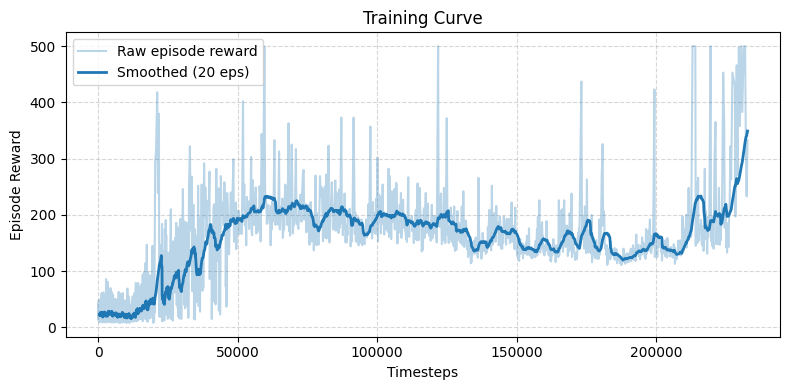

In [10]:

# 1) Where your Monitor wrote monitor.csv files:
log_dir = "./logs/"

# 2) Load & concatenate all Monitor logs under that folder:
data = load_results(log_dir)    # → pandas DataFrame

# 3) Extract (timesteps, episode_reward)
x, y = ts2xy(data, X_TIMESTEPS)

# 4) Smooth with a moving‐average window over N episodes:
window = 20
kernel = np.ones(window) / window
y_smooth = np.convolve(y, kernel, mode="valid")
x_smooth = x[window-1:]

# 5) Plot both raw and smoothed curves:
plt.figure(figsize=(8,4))
plt.plot(x,      y,        color="C0", alpha=0.3, label="Raw episode reward")
plt.plot(x_smooth, y_smooth, color="C0", linewidth=2, label=f"Smoothed ({window} eps)")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Training Curve")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

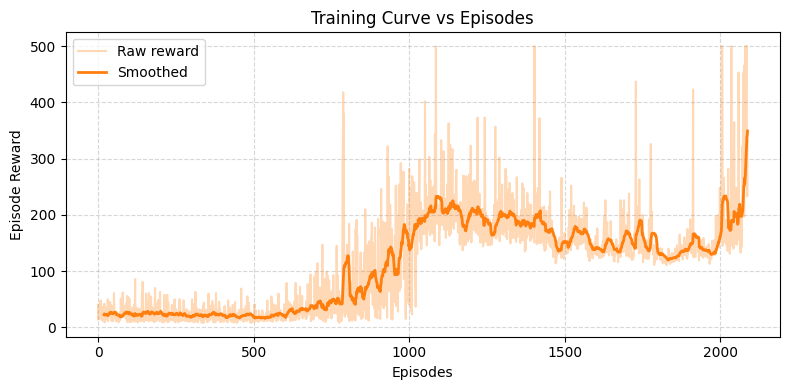

In [11]:
from stable_baselines3.common.results_plotter import X_EPISODES

xe, ye = ts2xy(data, X_EPISODES)
ys      = np.convolve(ye, kernel, mode="valid")
xe_s    = xe[window-1:]

plt.figure(figsize=(8,4))
plt.plot(xe,      ye,    color="C1", alpha=0.3, label="Raw reward")
plt.plot(xe_s,    ys,    color="C1", linewidth=2, label="Smoothed")
plt.xlabel("Episodes")
plt.ylabel("Episode Reward")
plt.title("Training Curve vs Episodes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Evaluate & Simulate

### 5.1 Quantitative Evaluation

Compute mean±std reward over 10 episodes:

In [26]:
mean_reward, std_reward = evaluate_policy(model, env_Monitor, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Mean reward: 500.00 ± 0.00


### 5.2 Visual Simulation

Run and render a few episodes:

In [27]:
# set maximum steps for episode to avoid endless loop if agent is "too good"
iSteps, nStepsMax = 0, 4000 
for ep in range(3):
    obs, info = env.reset()
    done = False
    total_r = 0.0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_r += reward
        iSteps += 1
        if iSteps > nStepsMax: 
            done = True
            iSteps = 0
    print(f"Episode {ep+1} cummulated reward: {total_r:.0f}")
env.close()

Episode 1 cummulated reward: 557
Episode 2 cummulated reward: 430
Episode 3 cummulated reward: 3014


In [30]:
def simulate_and_capture(model, env, max_steps=200):
    obs, _ = env.reset()
    frames = []
    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        if done or truncated:
            break
    return frames

# assume `model` and `env` are already defined
frames = simulate_and_capture(model, env)

fig = plt.figure(figsize=(4,4))
plt.axis('off')
im = plt.imshow(frames[0])

def update(i):
    im.set_data(frames[i])
    return (im,)

anim = animation.FuncAnimation(
    fig, update, frames=len(frames), interval=50, blit=True
)
plt.close(fig)    # don’t show the static plot


C:\Users\peter\anaconda3\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [32]:
# embed the animation in the notebook
HTML(anim.to_jshtml())

## 6. Save & Load the Trained Agent

In [ ]:
model.save("dqn_cartpole_sb3")
print('saved model')
# del model
## Later… 
# model = DQN.load("dqn_cartpole_sb3", env=env)

In [5]:
model = DQN.load("dqn_cartpole_sb3", env=env)


Wrapping the env in a DummyVecEnv.
